In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
from tqdm.auto import tqdm

## Reading data

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [3]:
len(train_df)

610

In [4]:
content = []
y = []

for i in tqdm(range(len(train_df))):
    file = train_df.loc[i, 'id']
    fname = f'{file}.mp4'
    label = train_df.loc[i, 'label']
    content.append(fname)
    y.append(label)

  0%|          | 0/610 [00:00<?, ?it/s]

In [5]:
content = np.array(content)
y = np.array(y)

In [6]:
content.shape, y.shape

((610,), (610,))

In [7]:
def read_frames(root_folder, arr, each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,128))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos

In [8]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [9]:
X_frames = read_frames('./data/train/', content)
X_frames = select_frames(X_frames, 30)

99.836


[ WARN:0@22.028] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@22.029] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin609 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@22.029] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@22.029] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16

(610, 30, 128, 128, 3)


In [10]:
xtr, xte, ytr, yte = train_test_split(X_frames, y, shuffle=True, test_size=0.2, random_state=42, stratify=train_df['label'])

In [19]:
xtr.shape, xte.shape, ytr.shape, yte.shape

((488, 30, 128, 128, 3), (122, 30, 128, 128, 3), (488,), (122,))

## Random Sample Visualization

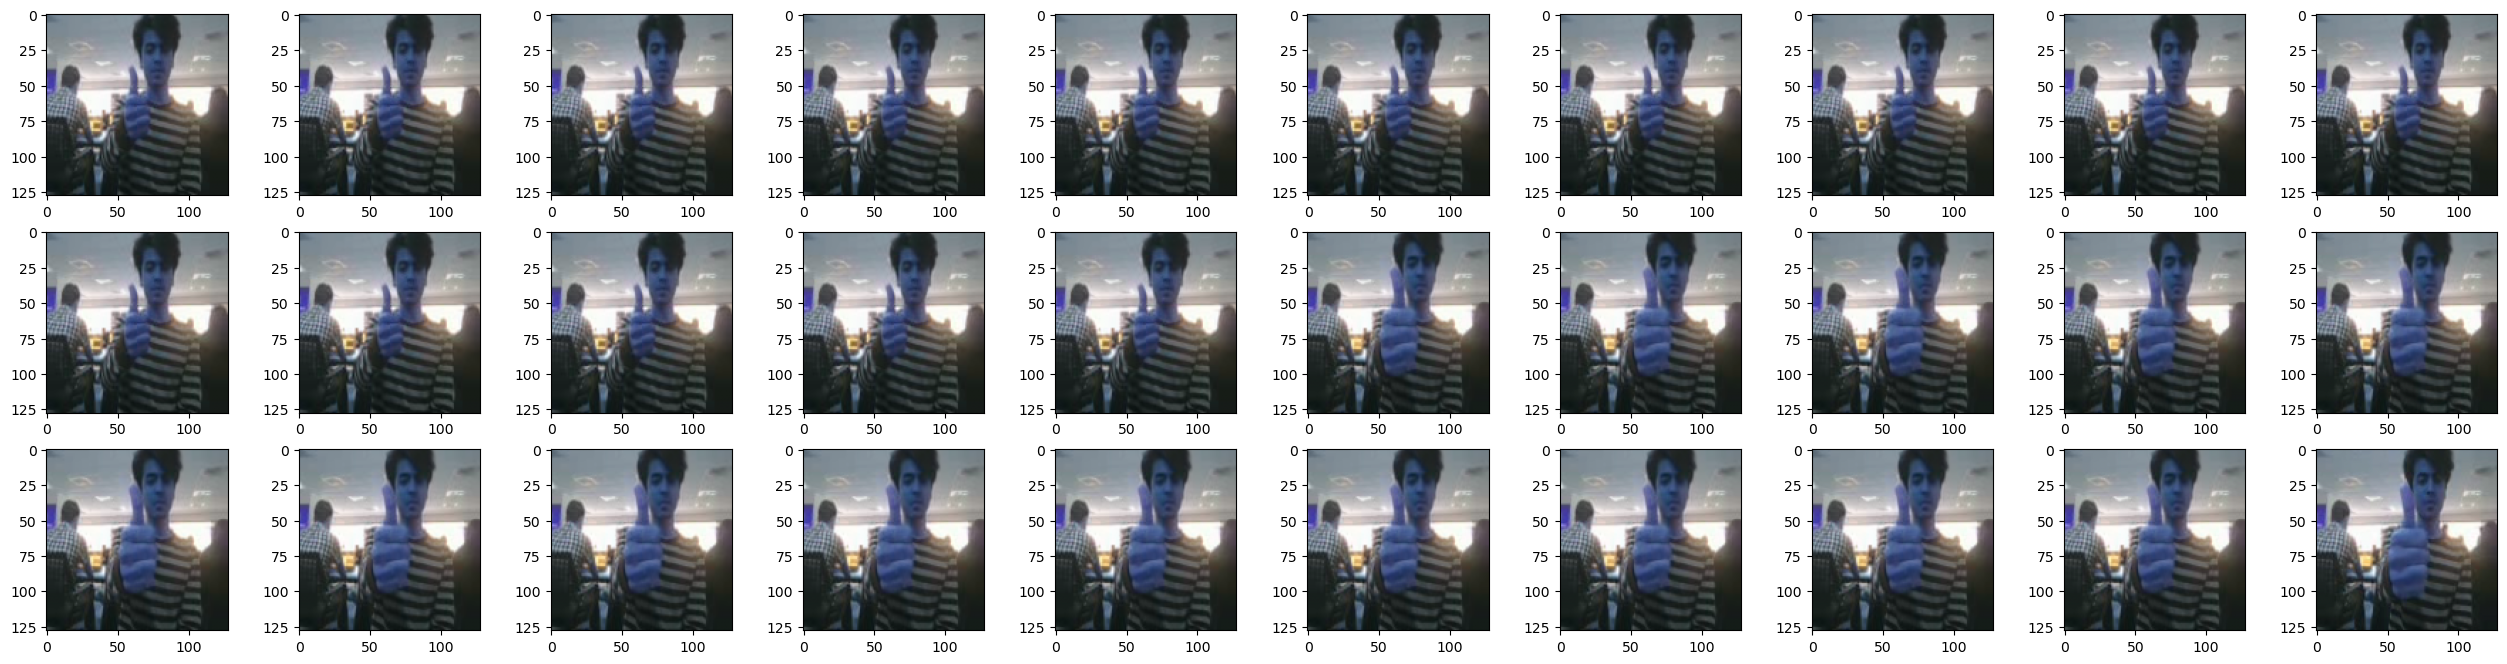

In [11]:
flg = plt.figure(figsize=(32, 8))
random_video_index = np.random.randint(0, len(X_frames))

for i, image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(3, 10, i+1)
    imshow(image)

## Building model

In [12]:
def list_to_stack(xs):
    xs = tf.stack(xs, axis = 1)
    s = tf.shape(xs)

    return xs

In [17]:
ish = (30, 128, 128, 3)
xs = []

inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    
  xs.append(x)
  

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*32*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(5, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 128, 12  0           []                               
                                8, 3)]                                                            
                                                                                                  
 lambda_22 (Lambda)             (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 lambda_23 (Lambda)             (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 lambda_24 (Lambda)             (None, 128, 128, 3)  0           ['input_3[0][0]']          

/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## model design

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Training model

In [18]:
history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/10


2023-01-25 19:28:50.679341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/batch_normalization_92/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/dg/0sf74rv51pj2sr7xt3hrvwkm0000gn/T/ipykernel_17798/336638912.py", line 1, in <module>
      history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/batch_normalization_92/FusedBatchNormV3'
Detected at node 'model_1/batch_normalization_92/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/dg/0sf74rv51pj2sr7xt3hrvwkm0000gn/T/ipykernel_17798/336638912.py", line 1, in <module>
      history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/hansanghui/opt/anaconda3/envs/dacon1/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/batch_normalization_92/FusedBatchNormV3'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  input must be 4-dimensional[10,10,32,32,50]
	 [[{{node model_1/batch_normalization_92/FusedBatchNormV3}}]]
	 [[model_1/dense_3/Softmax/_40]]
  (1) INVALID_ARGUMENT:  input must be 4-dimensional[10,10,32,32,50]
	 [[{{node model_1/batch_normalization_92/FusedBatchNormV3}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_23775]